<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/english_frame_token_0.2_gamma_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN based Korean summarizer using semi abstractive method


#4. Implementation


## 4.1 기본 설정...

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install keybert
!pip install sentence-transformers==0.3.0
!pip install transformers==3.0.2

#!pip install sentence-transformers

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 1.9MB 6.7MB/s 
     |████████████████████████████████| 890kB 47.8MB/s 
     |████████████████████████████████| 3.2MB 30.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-cp37-none-any.whl size=86754 sha256=851a094ed99ed2811b8707fd871a932ff3b08d816c7fe1e678fb3679716ea3c7
  Stored in directory: /root/.cache/pip/wheels/b8/23/85/85d6a9a6c68f0625a1ecdaad903bb0a78df058c10cf74f9de4
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=947fbe163fead24fbc8dbeceaefe2e57c689e4a6e1da03407d0f8fdd3ef7ca76
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 778kB 6.0MB/s 
     |████████████████████████████████| 3.0MB 40.1MB/s 
     |████████████████████████████████| 1.2MB 45.4MB/s 
  Fo

In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

GPU device not found


In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [6]:
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                print()
        self.back_filledLength = filledLength    

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

## CNN/Daily Mail dataset download...

In [9]:
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(name="cnn_dailymail",split=(tfds.Split.TRAIN,tfds.Split.TEST),with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.


In [10]:
train_data[0]

<PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>

In [11]:
sentences_dataset = []
gold_summary = []
iterator = iter(train_data[0])
cnt = 0
for data in iterator:
    cnt += 1
    if cnt < 1000:
        sentences_dataset.append(data['article'].numpy().decode('UTF-8'))
        gold_summary.append(data['highlights'].numpy().decode('UTF-8'))
    else:
        break

In [12]:
print(len(sentences_dataset))

999


##4.2 Grammar Discriminator Class

In [13]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 40:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pre_trained_model_name='bert-base-uncased', input_dir=None):

        if input_dir is None:
            print('Loading BERT tokenizer...')
            self.tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name, do_lower_case=True)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pre_trained_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)



    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', self.tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sentences[0])))   

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                loss, logits = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    (loss, logits) = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizer.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        loss, logits = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return loss, logits


###4.2.1 CNN/Daily Mail dataset으로 영어 문법 학습

In [ ]:
sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset[0:1])

In [ ]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [ ]:
k=5
print(labels[k])
print(sentences[k])

0
last newly The a for says attending in while he contaminated food the Italy through diocese conference infection bishops month contracted ordained


In [ ]:
len(sentences_dataset)

999

In [14]:
use_pretrained_model = True

if use_pretrained_model:
    #g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/model_save')
    g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/en_grammar_model')
else:
    sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences[0:500000],labels[0:500000])
    g_discriminator.train(epochs=2)
    g_discriminator.save_model()

Loading BERT tokenizer...


In [ ]:
if False: ## 추가적인 fine-tuning
    sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences[0:500000],labels[0:500000])
    g_discriminator.train(epochs=1)
    g_discriminator.save_model()

##4.3 Static similarity discriminator class

In [15]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='stsb-roberta-large'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 영어 문장 유사도 pre-trained model 적용

In [16]:
s_discriminator = Similarity_Discriminator(pre_trained_model_name="stsb-bert-base")
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


100%|██████████| 405M/405M [00:19<00:00, 20.9MB/s]


##4.4 Document source class

###4.4.1 keyBERT를 위한 pre-trained model의 적재

In [ ]:
#!pip install keybert

In [ ]:
#from keybert import KeyBERT
#key_model = KeyBERT('distilbert-base-nli-mean-tokens')

###4.4.2 frame term 추출을 위한 source class 구현

In [17]:


class Source:

    def __init__(self,org_text):
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()


    def extract_keywords(self,s_discriminator,key_model,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}
        index_table = {}
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''
        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        '''
        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #print('\n part_sen:',part_sen)
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative tokens:',terms[dup_order])
        '''

        top_n = int(len(self.term_table) * comp_rate)

        self.story_peaks = []
        keywords = key_model.extract_keywords(self.org_text,top_n=top_n)
        #print('keywords len',len(keywords))
        #print('keywords',keywords)
        for keyword,p in keywords:
            for k in self.term_table.keys():
                if self.term_table[k] == keyword: # and k not in dup_order:
                    self.story_peaks.append(k)

        self.story_peaks.append(len(self.term_table)-2)
        self.story_peaks = np.sort(np.asarray(self.story_peaks))
        print('story_peaks:',self.story_peaks)
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')    

    def set_key_rate(self,s_discriminator,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        top_n = int(len(self.term_table) * comp_rate)
        #print('top_n',top_n)
        self.story_peaks = [i+1 for i in range(top_n)]

    def analysis_frame_terms(self,s_discriminator,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0,comp_rate=0.2,except_key=True,display=False):

        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)

        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        if except_key:
            # story에 지배적인 word를 찾는다.
            # 먼저 word의 강세 분석
            for filter in word_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    word_weights[t] += score 

            # story의 강세 분석
            for filter in story_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    story_weights[t] += score

            #각각의 peak를 산출
            word_peaks, _ = find_peaks(word_weights, height=0)
            story_peaks, _ = find_peaks(story_weights, height=0)

            #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
            #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
            #이를 통해 story에 대한 word를 최대한 추출 한다.

            dup_order = []
            for i in range(self.org_source_length):
                #lst = ""
                if (i in word_peaks) and (i in story_peaks):
                    if terms[i].endswith('.'):
                        pass
                    else:
                        dup_order.append(i)
                        
            # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
            print('Negative tokens:',terms[dup_order])
            if except_key:
                terms[dup_order] = '---'
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code         Token      ')
        print('')
        for index, word in zip(range(len(terms)),terms):
            print( f'  {str(index).ljust(8)}    {word}')
        print('---------------------------------------------')
        '''
        self.story_weights = np.zeros(self.org_source_length,)
        # 그리고 다시 story 분석 스캔
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #part_sen = part_sen.replace('소녀','---')
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                self.story_weights[t] += score        


        # base line
        base_line = peak_base_line
        # 다시 peak 추출
        story_peaks, _ = find_peaks(self.story_weights, height=base_line)

        top_n = int(len(self.term_table) * comp_rate)

        if len(story_peaks) > top_n:
            peak_dict = {}
            for i,peak in zip(range(len(story_peaks)),story_peaks):
                peak_dict[peak] = self.story_weights[peak]
            #print(peak_dict)
            peaks = sorted(peak_dict, key=peak_dict.get, reverse=True)
            #print(peaks)
            peaks = peaks[:top_n]
            #print(peaks)
            peaks.sort()
            story_peaks = peaks
            #print(story_peaks)

        #print('top_n:',top_n,'story_peaks:',len(story_peaks))
        #print(story_peaks)
        
        self.story_peaks = np.append(story_peaks,len(story_weights)-2)
        #print(self.story_peaks)
        # story density 표출
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(self.story_weights)
            plt.plot(self.story_peaks, self.story_weights[self.story_peaks], "x")
            plt.plot(np.zeros_like(self.story_weights)+base_line, "--", color="gray")
            plt.show() 
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')      
        ''' 
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
   
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Score        Token              ')
        print('')
        for k in self.term_table.keys(): 
            print( f'  {str(k).ljust(5)}   {str(round(self.story_weights[k],4)).ljust(8)}  {self.term_table[k]}')

        print('---------------------------------------------') 
        '''
    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

##4.5 Generator class

In [18]:
from functools import reduce

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*3),
            nn.LeakyReLU(0.2),            
            nn.Linear(input_size*3, input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''
    def forward(self, x, story_peaks, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y_[:,story_peaks] += bias
        y_ = nn.Sigmoid()(y_)
        #reduce(torch.add, [y_,bias]) / 2
        return y_
    '''

    
    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

    '''    
    def forward(self, x):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        #y = torch.add(y_,bias)
        y = nn.Sigmoid()(y_)

        return y, y_    
    '''    

##4.6 Summarizer class (GAN training)

In [19]:
import random
import math
import numpy as np
from scipy.special import expit

class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        self.s_discriminator = s_discriminator
        self.m = nn.Sigmoid()

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)

        return self

    def summarize(self,epochs=10,batch_size=2,frame_expansion_ratio = 0.8,init_bias = 1.0,learning_rate=2e-4, display = False):
        self.frame_expansion_ratio = frame_expansion_ratio
        history = self.__train(epochs,batch_size,init_bias,learning_rate,display)
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='generator grammar loss')
            plt.plot(history['gen_s_loss'],label='generator similarity loss')
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return self

    # text의 생성 for torch
    def __text_gen2(self, noise, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(noise, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __discrete_gradient(self,weights,gen_length,beta,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)

        real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            gtext = self.__text_gen2(noise,gen_length)
            tw = ""
            tk = []
            fake_scores = []
            for (w,k) in gtext:
                tw += w + ' '
                tk.append(k)
                if w.endswith('.'):
                    fake_outs.append(tw.strip())
                    real_outs.append(real_text[i])
                    apply_order.append((i,tk))
                    tw = ""
                    tk = []
                    
            if len(tk) > 0:
                fake_outs.append(tw.strip())
                real_outs.append(real_text[i])
                apply_order.append((i,tk))

        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)
        D_x_loss, real_gmr_out=self.g_discriminator.transfer_learning(real_outs,train_for = True)   # not use of 'real_gmr_out'

        f_sim_out = []
        for fake_text in fake_outs:
            f_sim_out.append(self.s_discriminator.similarity(fake_text,self.source.org_text_emb))

        #if use_gpu:
        #    apply_order = torch.FloatTensor(apply_order).to(device)  
        
        #print(fake_dis_out)
        
        for j, (i,tk) in enumerate(apply_order):
            #fake_gen_out[i,tk] += fake_dis_out[j].numpy() --> 이거는 tf 용...
            #fake_gen_out[i,tk] += fake_dis_out[j] #.cpu().detach().numpy()
            # 
            try:
                #print('fake_gmr_out:',fake_gmr_out[j,1])
                #print('real_gmr_out:',real_gmr_out[j,1])
                #fake_gen_out[i,tk] += torch.sigmoid(fake_gmr_out[j,1])

                fake_gen_out[i,tk] += torch.tanh( fake_gmr_out[j,1])
                fake_sim_out[i,tk] += f_sim_out[j] * beta
                
            except Exception as ex:
                print(j,i,tk)
                print(fake_gmr_out)
                raise ex

        return fake_gen_out, fake_sim_out, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10,init_bias = 1.0,learning_rate=2e-4, display = False):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = 10

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        D1_opt = AdamW(self.g_discriminator.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        self.bias_w = init_bias
        initial_bias = 0
        G_s_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)

        beta = 1

        for i in range(epochs):
            '''
            noise = torch.randn(batch_size,self.source.org_source_length).to(device)
            bias = torch.zeros_like(noise).to(device)
            bias[:,self.source.story_peaks] += self.bias_w 
            with torch.no_grad():        
                sw, sw0 = self.generator(noise,bias)

            self.g_discriminator.discriminator.train()          #discriminator는 evaluation 모드로 전환
            fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
            
            D_loss = D_x_loss + D_z_loss      

            self.g_discriminator.discriminator.zero_grad()
            D_loss.backward()
            D1_opt.step()
            self.g_discriminator.discriminator.eval()
            '''
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device)
                bias = torch.zeros_like(noise).to(device)
                bias[:,self.source.story_peaks] += self.bias_w

                sw, sw0 = self.generator(noise,bias)

                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length,beta)
                
                '''
                if int(i/10)%2 == 0:  # grammar와 similarity를 각각 한번씩 교대로 학습한다?
                    sw1 = sw * fake_sim_out
                    G_s_loss = -torch.mean(sw1)
                    G_loss = G_s_loss    
                else: #if i%2 == 1:
                    sw1 = sw * fake_gmr_out
                    G_g_loss = -torch.mean(sw1)
                    G_loss = G_g_loss
                '''
                sw1 = sw * fake_sim_out
                G_s_loss = -torch.mean(sw1)
                sw2 = sw * fake_gmr_out
                G_g_loss = -torch.mean(sw2)

                G_loss =  G_g_loss + G_s_loss
                
                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                #self.generator.eval()
            #print('step:')
            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())

            beta = self.m(-(G_g_loss-G_s_loss)*10) * 4

            if math.isnan(beta) or beta > 5:
                beta = 1

            pb.printProgress(+1,f'{i+1}/{epochs} epochs, beta:{beta} Generator / grammar loss:{G_g_loss}   similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            
            
        self.generator.eval()
        self.g_discriminator.discriminator.eval()
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(sw0[0].cpu().detach().numpy(),label='before activation weights')
            plt.plot(sw[0].cpu().detach().numpy(),label='after activation weights')
            plt.plot(bias[0].cpu().detach().numpy(),label='bias weights')
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history} #,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        texts = []
        self.generator.cpu()
        self.generator.eval()
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #bias = torch.randn(1,self.source.org_source_length)
        bias[:,self.source.story_peaks] += self.bias_w #self.last_bias_max.cpu().detach().numpy()
        #bias = 0
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        for noise in sw:
            gtext = self.__text_gen2(noise,gen_length)
            text = ' '.join([w for (w,k) in gtext])
            #print(text)
            texts.append(text)
        return texts

#5. Experiment

## 비교 대상 요약 알고리즘 준비

In [20]:
!pip install rouge-score

In [21]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [22]:
print('rouge1', scores['rouge1'].fmeasure)
print('rouge2', scores['rouge2'].fmeasure)
print('rougeL', scores['rougeL'].fmeasure)


rouge1 0.7058823529411765
rouge2 0.26666666666666666
rougeL 0.5882352941176471


In [23]:
def similarity(query_text, org_text):
    sentences = nltk.sent_tokenize(org_text)
    #print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(query_text)
    #print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

def grammarity(text):
    
    input_ids = []
    attention_masks = []

    sentences = np.asarray(nltk.sent_tokenize(text))
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = g_discriminator.tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation = True,
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    g_discriminator.discriminator.to(device)
    #if str(discriminator1.device) == 'cpu':
    #    pass
    #else:
    #    input_ids = input_ids.to(device)
    #    attention_masks = attention_masks.to(device)        

    with torch.no_grad():        
        outputs = g_discriminator.discriminator(input_ids, 
                               token_type_ids=None, 
                               attention_mask=attention_masks)
    #return torch.sigmoid(outputs[0][:,1])
    return torch.mean(outputs[0][:,1]).detach().cpu().numpy()
    #return outputs

In [24]:
import pandas as pd
import numpy as np

def evaluate(method_name, text, g_summ, org_text_1,org_text_2,org_text_3):
    result = {}
    result['method'] = [method_name]
    org_text = org_text_1 + ' ' + org_text_2 + ' ' + org_text_3
    result['comp ratio'] = [len(text)/len(org_text)]
    result['intro'] = [similarity(text,org_text_1)]
    result['body'] = [similarity(text,org_text_2)]
    result['ending'] = [similarity(text,org_text_3)]
    result['var'] = [np.var([result['intro'][0],result['body'][0],result['ending'][0]])]
    result['total'] = [similarity(text,org_text)]
    result['grammar'] = [np.tanh(float(grammarity(text)))]
    scores = scorer.score(g_summ,text)
    result['R1'] = [scores['rouge1'].fmeasure]
    result['R2'] = [scores['rouge2'].fmeasure]
    result['RL'] = [scores['rougeL'].fmeasure]
    return pd.DataFrame(result),result

In [25]:
"""
LexRank implementation
Source: https://github.com/crabcamp/lexrank/tree/dev
"""

import numpy as np
from scipy.sparse.csgraph import connected_components

def degree_centrality_scores(
    similarity_matrix,
    threshold=None,
    increase_power=True,
):
    if not (
        threshold is None
        or isinstance(threshold, float)
        and 0 <= threshold < 1
    ):
        raise ValueError(
            '\'threshold\' should be a floating-point number '
            'from the interval [0, 1) or None',
        )

    if threshold is None:
        markov_matrix = create_markov_matrix(similarity_matrix)

    else:
        markov_matrix = create_markov_matrix_discrete(
            similarity_matrix,
            threshold,
        )

    scores = stationary_distribution(
        markov_matrix,
        increase_power=increase_power,
        normalized=False,
    )

    return scores


def _power_method(transition_matrix, increase_power=True):
    eigenvector = np.ones(len(transition_matrix))

    if len(eigenvector) == 1:
        return eigenvector

    transition = transition_matrix.transpose()

    while True:
        eigenvector_next = np.dot(transition, eigenvector)

        if np.allclose(eigenvector_next, eigenvector):
            return eigenvector_next

        eigenvector = eigenvector_next

        if increase_power:
            transition = np.dot(transition, transition)


def connected_nodes(matrix):
    _, labels = connected_components(matrix)

    groups = []

    for tag in np.unique(labels):
        group = np.where(labels == tag)[0]
        groups.append(group)

    return groups


def create_markov_matrix(weights_matrix):
    n_1, n_2 = weights_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'weights_matrix\' should be square')

    row_sum = weights_matrix.sum(axis=1, keepdims=True)

    return weights_matrix / row_sum


def create_markov_matrix_discrete(weights_matrix, threshold):
    discrete_weights_matrix = np.zeros(weights_matrix.shape)
    ixs = np.where(weights_matrix >= threshold)
    discrete_weights_matrix[ixs] = 1

    return create_markov_matrix(discrete_weights_matrix)


def graph_nodes_clusters(transition_matrix, increase_power=True):
    clusters = connected_nodes(transition_matrix)
    clusters.sort(key=len, reverse=True)

    centroid_scores = []

    for group in clusters:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        centroid_scores.append(eigenvector / len(group))

    return clusters, centroid_scores


def stationary_distribution(
    transition_matrix,
    increase_power=True,
    normalized=True,
):
    n_1, n_2 = transition_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'transition_matrix\' should be square')

    distribution = np.zeros(n_1)

    grouped_indices = connected_nodes(transition_matrix)

    for group in grouped_indices:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        distribution[group] = eigenvector

    if normalized:
        distribution /= n_1

    return distribution


* Hands-on Guide To Extractive Text Summarization With BERTSum<br>
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/ <br>
https://pypi.org/project/bert-extractive-summarizer/

In [26]:
!pip install bert-extractive-summarizer

In [27]:
def bert_lexrank_sum(g_summ,org_text,n_top=5):
    input_text = org_text[0] + org_text[1] + org_text[2]
    #Split the document into sentences
    sentences = nltk.sent_tokenize(input_text)
    #print("Num sentences:", len(sentences))

    #Compute the sentence embeddings
    embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    #util.pytorch_cos_sim(embeddings, embeddings).numpy()
    #print(cos_scores)
    #Compute the centrality for each sentence
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    #We argsort so that the first element is the sentence with the highest score
    most_central_sentence_indices = np.argsort(-centrality_scores)

    #Print the 5 sentences with the highest scores
    summary_text = ""
    for idx in most_central_sentence_indices[0:n_top]:
        summary_text += sentences[idx].strip()
    print('bert_lexrank summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('BERT+LexRank',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr


In [28]:

from summarizer import Summarizer


model1 = Summarizer()


def besm(g_summ,org_text):
    result = model1(org_text[0] + org_text[1] + org_text[2], num_sentences=3)
    summary_text = "".join(result)
    print('besm summary:')
    print(summary_text)
    print('-'*50)    
    df,arr = evaluate('BESM',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

In [29]:
from transformers import AutoConfig,AutoTokenizer,AutoModel

#SQUAD_MODEL = "monologg/kobert"

SQUAD_MODEL = "bert-large-uncased"
# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained(SQUAD_MODEL)
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained(SQUAD_MODEL)
custom_model = AutoModel.from_pretrained(SQUAD_MODEL, config=custom_config)

model2 = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

def besm_bert(g_summ,org_text):
    result = model2(org_text[0].lower() + org_text[1].lower() + org_text[2].lower(), num_sentences=3)
    summary_text = "".join(result)
    print('besm_bert summary:')
    print(summary_text)
    print('-'*50)      
    df,arr = evaluate('BESM+kobert',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

## Absrtract method

In [30]:
from transformers import pipeline

# using pipeline API for summarization task
summarization = pipeline("summarization")

In [31]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer

# initialize the model architecture and weights
t5_sum_model = T5ForConditionalGeneration.from_pretrained("t5-base")
# initialize the model tokenizer
# tokenizer = T5Tokenizer.from_pretrained("t5-small")  --> 계속 에러...
t5_sum_tokenizer = AutoTokenizer.from_pretrained("t5-base") #deepset/bert-base-cased-squad2")

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
original_text = """
Paul Walker is hardly the first actor to die during a production. 
But Walker's death in November 2013 at the age of 40 after a car crash was especially eerie given his rise to fame in the "Fast and Furious" film franchise. 
The release of "Furious 7" on Friday offers the opportunity for fans to remember -- and possibly grieve again -- the man that so many have praised as one of the nicest guys in Hollywood. 
"He was a person of humility, integrity, and compassion," military veteran Kyle Upham said in an email to CNN. 
Walker secretly paid for the engagement ring Upham shopped for with his bride. 
"We didn't know him personally but this was apparent in the short time we spent with him. 
I know that we will never forget him and he will always be someone very special to us," said Upham. 
The actor was on break from filming "Furious 7" at the time of the fiery accident, which also claimed the life of the car's driver, Roger Rodas. 
Producers said early on that they would not kill off Walker's character, Brian O'Connor, a former cop turned road racer. Instead, the script was rewritten and special effects were used to finish scenes, with Walker's brothers, Cody and Caleb, serving as body doubles. 
There are scenes that will resonate with the audience -- including the ending, in which the filmmakers figured out a touching way to pay tribute to Walker while "retiring" his character. At the premiere Wednesday night in Hollywood, Walker's co-star and close friend Vin Diesel gave a tearful speech before the screening, saying "This movie is more than a movie." "You'll feel it when you see it," Diesel said. "There's something emotional that happens to you, where you walk out of this movie and you appreciate everyone you love because you just never know when the last day is you're gonna see them." There have been multiple tributes to Walker leading up to the release. Diesel revealed in an interview with the "Today" show that he had named his newborn daughter after Walker. 
Social media has also been paying homage to the late actor. A week after Walker's death, about 5,000 people attended an outdoor memorial to him in Los Angeles. Most had never met him. Marcus Coleman told CNN he spent almost $1,000 to truck in a banner from Bakersfield for people to sign at the memorial. "It's like losing a friend or a really close family member ... even though he is an actor and we never really met face to face," Coleman said. "Sitting there, bringing his movies into your house or watching on TV, it's like getting to know somebody. It really, really hurts." Walker's younger brother Cody told People magazine that he was initially nervous about how "Furious 7" would turn out, but he is happy with the film. "It's bittersweet, but I think Paul would be proud," he said. CNN's Paul Vercammen contributed to this report.
"""
summary_text = summarization(original_text)[0]['summary_text']
print("Summary:", summary_text)

Summary:  Paul Walker died in November 2013 after a car crash in Los Angeles . The late actor was one of the nicest guys in Hollywood . The release of "Furious 7" on Friday offers a chance to grieve again . There have been multiple tributes to Walker leading up to the film's release .


In [33]:
def abstract_method_1(g_summ,org_text):
    original_text = org_text[0] + org_text[1] + org_text[2]
    summary_text = summarization(original_text)[0]['summary_text']
    print('transformer summary:')
    print(summary_text)
    print('-'*50)         
    df,arr = evaluate('transformer',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

In [34]:
def abstract_method_2(g_summ,org_text):
    original_text = org_text[0] + org_text[1] + org_text[2]
    inputs = t5_sum_tokenizer.encode("summarize: " + original_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = t5_sum_model.generate(
        inputs, 
        max_length=150, 
        min_length=40, 
        length_penalty=2.0, 
        num_beams=4, 
        early_stopping=True)
    # just for debugging
    #print(outputs)
    summary_text = t5_sum_tokenizer.decode(outputs[0])
    print('T5 summary:')
    print(summary_text)
    print('-'*50)         
    df,arr = evaluate('T5',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

## CNN / Daily Mail 실험

In [35]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [36]:
gold_summary[0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [37]:
def __crean_text(txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()

def clear_article(txt):
    article = []
    txt= __crean_text(txt)
    for l in txt.split('.'):
        if len(l) > 30:
            article += l+'.'
    txt = (''.join(article)).strip()
    pt = txt.split('.')
    lt = len(pt)
    intro_size = int(lt*0.2+0.5)
    body_size = int(lt*0.5+0.5)
    end_size = int(lt*0.3+0.5)
    #print(intro_size,body_size,end_size)
    intro = pt[0:intro_size]
    body = pt[intro_size:intro_size+body_size]
    end = pt[intro_size+body_size:]
    #print(intro_size,body_size,end_size)
    #for l in txt.split('.'):
    
    return  ('.'.join(intro)).strip()+'.',('.'.join(body)).strip()+'.',('.'.join(end)).strip()

In [38]:
intro,body,end = clear_article(sentences_dataset[50])
print(intro)
print(body)
print(end)

Fears are growing that Britains jails are becoming a hotbed of extremism after it was revealed today that nearly half the inmates of one top security prison are Muslim. Some 42 per cent of those housed at Category A Whitemoor jail - and more than a quarter of those in London prisons - consider themselves to be of Islamic faith. Experts now fear large numbers are being radicalised on the inside, where they say the spread of Jihadist ideas is rife. Figures show more than a quarter of inmates in London jails are Muslim, with one Category A jail revealing 42 per cent of its convicts follow the Islamic faith.
Whitemoor inmate Zia Al Haq, left, was jailed for 18 for planning bomb attacks in London while Nezar Hindawi, right, was handed a 45-year sentence for plotting to blow up a jet. A source at Cambridgeshire jail Whitemoor told the Sunday People: Whitemoor is now effectively run by Muslims, many of whom are Jihadis. A 2012 probe into the jail branded it a Taliban recruiting ground and sai

In [39]:
org_text_1,org_text_2,org_text_3 = clear_article(sentences_dataset[4])
g_summ = gold_summary[4]

In [40]:
def sam_wgan(g_summ,org_text,init_bias=0.0, display = False):
    source = Source(org_text[0] + org_text[1] + org_text[2])
    if init_bias > 0:
        source.analysis_frame_terms(s_discriminator,comp_rate=0.05,except_key=True,display=display)
    else:
        #source.extract_keywords(s_discriminator,key_model, comp_rate=0.1)
        source.set_key_rate(s_discriminator,comp_rate=0.05)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    summarizer.summarize(epochs=500,batch_size=1,frame_expansion_ratio = 2.0, init_bias=init_bias,learning_rate=5e-5,display=display)
    summary_text = summarizer.get_summary(3)[0]
    print('-'*50)
    print('gold summary:')
    print(g_summ)    
    print('-'*50)
    print('sam_wgan summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('SAM+WGAN',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

Test용 Data 준비

------------------------------------------------------------------
There are a number of job descriptions waiting for Darren Fletcher when he settles in at West Brom but the one he might not have expected is Saido Berahino’s nanny. Fletcher’s unveiling as the deadline day signing from Manchester United was almost eclipsed by the 21-year-old striker, who is acquiring the habit of talking himself into trouble. Ten years Berahino’s senior, Fletcher will be expected to mentor a player who told the world this week that he wanted to play for a bigger club. Tony Pulis has advised Saido Berahino to focus on his performances at West Brom. Darren Fletcher has signed for the baggies where he will be asked to provide a role model for young players. On it, the Scotland midfielder wants to prove he is good enough to cut the mustard in the Premier League after finding starts harder and harder to come by at Old Trafford. Head coach Tony Pulis believes that Fletcher, who has agreed a three-and-a-half y

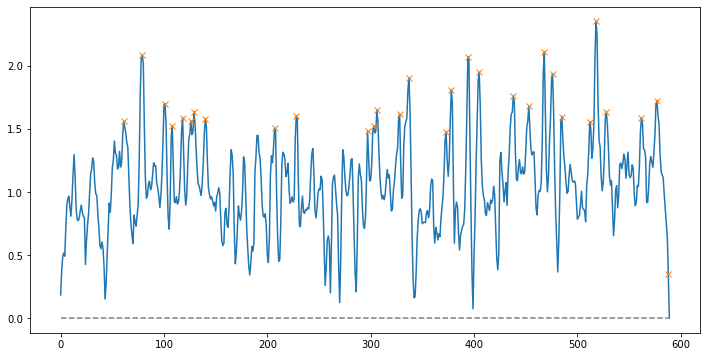

Peak count: 30
Frame tokens: senior, to has will players. prove good finding be has youngsters notice. Fletch him got message He great recent His his players Hes was He will to goalscorer. kid season. 

Similarity : 0.37874323134855237
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.3900275230407715 Generator / grammar loss:-0.10755467414855957   similarity loss:-0.06804589927196503


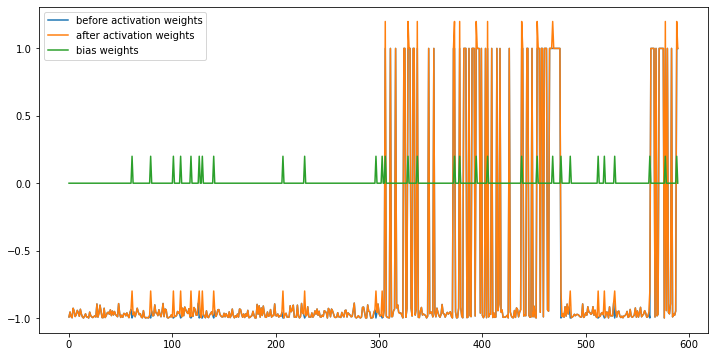

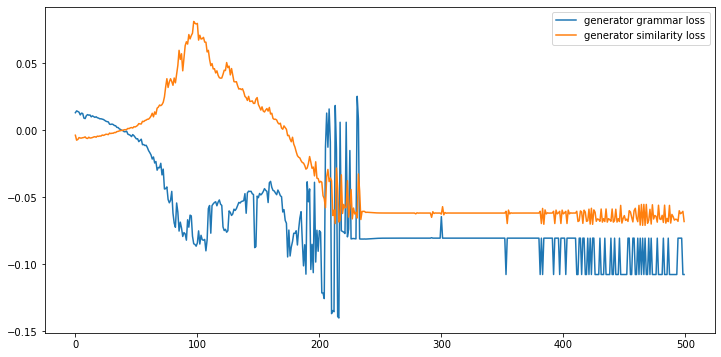

--------------------------------------------------
gold summary:
Tony Pulis believes Saido Berahino should look up to Darren Fletcher .
Pulis insists Berahino has been listened to the wrong advice .
Berahino said he wants to move on to bigger things earlier in the week .
READ: Berahino available for £20m after Liverpool target angers club .
CLICK HERE for all the latest West Brom news .
--------------------------------------------------
sam_wgan summary:
senior, to has will prove good finding be has youngsters notice. Fletch that give character, having him for a is first got as the underlying message He listening to all This great football club great players. And Saido not Pulis recent and an model like His responsibility for us ‘Ive his people. He to do rather than talk Thats what good players do and then clubs will be interested. Hes was He will to goalscorer. Giving me orders straight because to score goals. He’s a kid respectful big season. 
----------------------------------------

,method,comp ratio,intro,body,ending,var,total,grammar,R1,R2,RL
0,SAM+WGAN,0.152765,0.400633,0.427153,0.585088,0.00663,0.465867,-0.132397,0.194444,0.014085,0.097222


In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

num = 8

org_text_1,org_text_2,org_text_3 = clear_article(sentences_dataset[num])
g_summ = gold_summary[num]

df1,_ = sam_wgan(g_summ,[org_text_1,org_text_2,org_text_3],init_bias=0.2,display= True)
#df2,_ = bert_lexrank_sum(g_summ,[org_text_1,org_text_2,org_text_3])
#df3,_ = besm(g_summ,[org_text_1,org_text_2,org_text_3])
#df4,_ = besm_bert(g_summ,[org_text_1,org_text_2,org_text_3])
#df5,_ = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
#df6,_ = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])
#result = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
#result = pd.concat([df1, df2, df3, df5, df6], ignore_index=True)
df1


In [41]:
import sys

def get_features(dct1):
    return [dct1['comp ratio'][0],dct1['intro'][0],dct1['body'][0],dct1['ending'][0],dct1['var'][0],dct1['total'][0],dct1['grammar'][0],dct1['R1'][0],dct1['R2'][0],dct1['RL'][0]]

test_result = {}
test_result['SAM+WGAN']=[]
test_result['BERT+LexRank']=[]
test_result['BESM']=[]
test_result['BESM+kobert']=[]
test_result['Transformer']=[]
test_result['T5']=[]

In [42]:
def get_test_statistics(test_result):
    df_data = {}
    df_data['method'] = []
    df_data['comp rate'] = []
    df_data['intro'] = []
    df_data['body'] = []
    df_data['conclusion'] = []
    df_data['isthmus'] = []
    df_data['simlirality'] = []
    df_data['grammarity'] = []
    df_data['R1'] = []
    df_data['R2'] = []
    df_data['RL'] = []
    for key in test_result:
        df_data['method'].append(key)
        data = np.asarray(test_result[key])
        df_data['comp rate'].append(np.mean(data[:,0]))
        df_data['intro'].append(np.mean(data[:,1]))
        df_data['body'].append(np.mean(data[:,2]))
        df_data['conclusion'].append(np.mean(data[:,3]))
        df_data['isthmus'].append(np.mean(data[:,4]))
        df_data['simlirality'].append(np.mean(data[:,5]))
        df_data['grammarity'].append(np.mean(data[:,6]))
        df_data['R1'].append(np.mean(data[:,7]))
        df_data['R2'].append(np.mean(data[:,8]))
        df_data['RL'].append(np.mean(data[:,9]))

    df = pd.DataFrame(df_data)
    return df

In [43]:
def prepare_data(offset,length):
    document = []
    for i,doc in zip(range(offset,offset+length),sentences_dataset[offset:offset+length]):
        intro,body,end = clear_article(doc)
        document.append([gold_summary[i],intro,body,end])

    return document


document = prepare_data(0,70)


In [ ]:
document[5]

['Prime Minister and his family are enjoying an Easter break in Lanzarote .\nSported the same £20.99 beige loafers as he wore in Portugal last year .\nPM sat and had a drink at a beach-side cafe on the Spanish Island .',
 'Hes been accused of making many a fashion faux pas while on holiday. But the Prime Minister seems to be deaf to his critics. Yesterday David Cameron was seen in the same pair of beige loafers he wore on holiday last year. Mr Cameron, who is in Lanzarote with his family, got\xa0 the £20. 99 shoes from high street store Aldo and took them with him to Portugal last summer.',
 'Retread: David Cameron with Samantha yesterday. And yes - hes wearing the same shoes. David Cameron and Samantha in Portugal last year - where he debuted his beige loafers. Yesterday he teamed them with a casual. navy blue shirt and beige shorts on a trip to Teguise in the centre of. ever fashion consultant Mrs Cameron trumped her husband in the style. stakes, wearing an elegant black maxi dress a

## No Frame token 실험

1 / 70
------------------------------------------------------------------
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A. State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms o

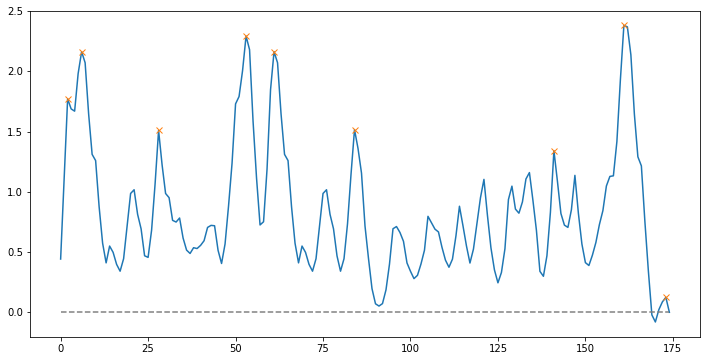

Peak count: 9
Frame tokens: bishop Catholic virus communion. Catholic Immunization ordained Fargo located. 

Similarity : 0.3668705121226299
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.365473508834839 Generator / grammar loss:-0.15409107506275177   similarity loss:-0.11712855845689774177


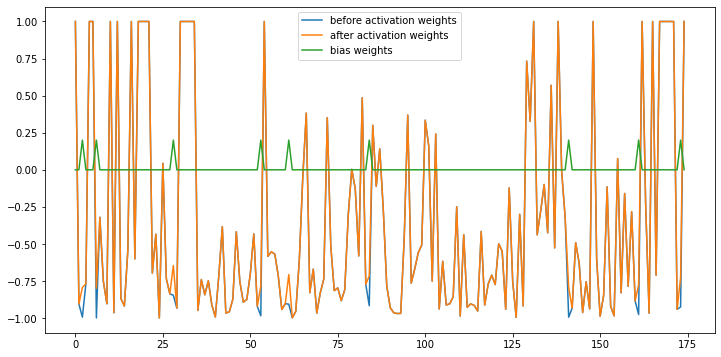

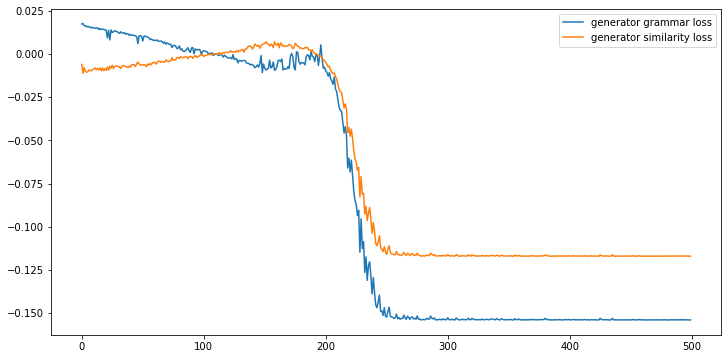

--------------------------------------------------
gold summary:
Bishop John Folda, of North Dakota, is taking time off after being diagnosed .
He contracted the infection through contaminated food in Italy .
Church members in Fargo, Grand Forks and Jamestown could have been exposed .
--------------------------------------------------
sam_wgan summary:
 the Fargo Dakota exposed church in Fargo, Grand Forks late September and early October. Bishop infection conference of Catholic North (pictured) is where the bishop 
--------------------------------------------------
bert_lexrank summary:
State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure.The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month.The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A.S

Frame token scan: ||...................| 5.1%   filer:[0] 374/393       

KeyboardInterrupt: 

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

step = 0
for g_summ,intro,body,end in document:
    step += 1
    print("=" * 50)
    print(str(step),"/",len(document))
    print("=" * 50)
    
    org_text_1 = intro
    org_text_2 = body
    org_text_3 = end

    try:
        df1,dct1 = sam_wgan(g_summ,[org_text_1,org_text_2,org_text_3],init_bias=0.0,display= True)
        if dct1['grammar'][0] > 0.0:
            df2,dct2 = bert_lexrank_sum(g_summ,[org_text_1,org_text_2,org_text_3])
            df3,dct3 = besm(g_summ,[org_text_1,org_text_2,org_text_3])
            df4,dct4 = besm_bert(g_summ,[org_text_1,org_text_2,org_text_3])
            df5,dct5 = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
            df6,dct6 = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])

            test_result['SAM+WGAN'].append(get_features(dct1))
            test_result['BERT+LexRank'].append(get_features(dct2))
            test_result['BESM'].append(get_features(dct3))
            test_result['BESM+kobert'].append(get_features(dct4))
            test_result['Transformer'].append(get_features(dct5))
            test_result['T5'].append(get_features(dct6))
            result = pd.concat([df1, df2, df3, df4, df5, df6 ], ignore_index=True)
            #result = pd.concat([df1, df2, df3, df5, df6 ], ignore_index=True)
            
            print(result)
            
            print("Current result","=" * 50)
            print("Sample count:",len(test_result['SAM+WGAN']))
            print(get_test_statistics(test_result))
        
    except KeyboardInterrupt as ki:
        raise ki
    except :
        print("Unexpected error:", sys.exc_info()[0])
        #raise e
        pass

get_test_statistics(test_result)

## Frame token 실험

1 / 70
------------------------------------------------------------------
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A. State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms o

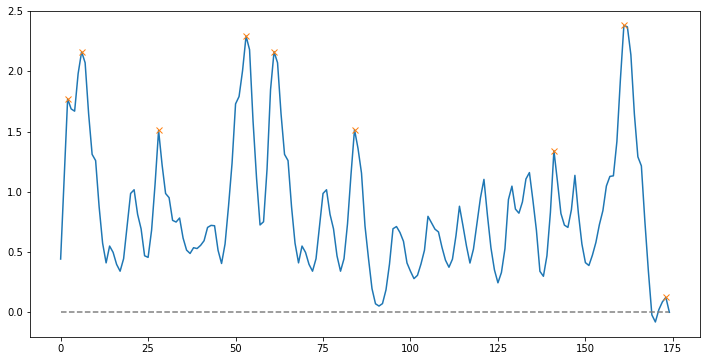

Peak count: 9
Frame tokens: bishop Catholic virus communion. Catholic Immunization ordained Fargo located. 

Similarity : 0.3668705332683295
Train... |||||................| 20.0%   100/500 epochs, beta:2.0433621406555176 Generator / grammar loss:-0.0030992310494184494   similarity loss:0.0012376544764265418

KeyboardInterrupt: ignored

In [44]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

test_result = {}
test_result['SAM+WGAN']=[]

step = 0
for g_summ,intro,body,end in document:
    step += 1
    print("=" * 50)
    print(str(step),"/",len(document))
    print("=" * 50)
    
    org_text_1 = intro
    org_text_2 = body
    org_text_3 = end

    try:
        df1,dct1 = sam_wgan(g_summ,[org_text_1,org_text_2,org_text_3],init_bias=0.2,display= True)
        if dct1['grammar'][0] > 0.0:

            test_result['SAM+WGAN'].append(get_features(dct1))
            #result = pd.concat([df1, df2, df3, df4, df5, df6 ], ignore_index=True)
            #result = pd.concat([df1, df2, df3, df5, df6 ], ignore_index=True)
            
            print(df1)
            
            print("Current result","=" * 50)
            print("Sample count:",len(test_result['SAM+WGAN']))
            print(get_test_statistics(test_result))
        
    except KeyboardInterrupt as ki:
        raise ki
    except :
        print("Unexpected error:", sys.exc_info()[0])
        #raise e
        pass

get_test_statistics(test_result)

## Reference

[1] Rada Mihalcea and Paul Tarau, (2004). TextRank: Bringing Order into Texts <br>
[2] G¨une¸s Erkan. (2004). LexRank: Graph-based Lexical Centrality as Salience in Text Summarization <br>
[3] Susan T. Dumais (2005). "Latent Semantic Analysis". Annual Review of Information Science and Technology. 38: 188–230. <br>
[4] Hans Peter Luhn (1960). Keyword-in-context index for technical literature. American Documentation, 11(4):288–295. ISSN 0002-823 <br>
[5] Aria Haghighi, (2009). Exploring Content Models for Multi-Document Summarization <br>
[6] Colin Raffel. (2020). Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer <br>
[7] Mike Lewis, (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension <br>
[8] Alec Radford, (2018). Language Models are Unsupervised Multitask Learners <br>
[9] Guillaume Lample, (2019). Cross-lingual Language Model Pretraining <br>
[10] Nils Reimers and Iryna Gurevych, (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks <br>
[11] Sharma, P., & Li, Y. (2019). Self-Supervised Contextual Keyword and Keyphrase Retrieval with Self-Labelling <br>
[12] Jacob Devlin, (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding <br>
[13] Ian J. Goodfellow, (2014). Generative Adversarial Nets <br>
[14] Yau-ShianWang, (2018). Learning to Encode Text as Human-Readable Summaries using Generative Adversarial Networks <br>
[15] Martin Arjovsky, (2017). Wasserstein GAN <br>